# Movies Example - Predicing the "NaN"-values

Author: Andreas Traut

In this example I used a dataset which contains the following columns: 

 Rank | Title | Year | Score | Metascore | Genre | Vote | Director | Runtime | **Revenue** | Description | RevCat

My aim was to predict the **Revenue** based on the other information. There are some "NaN"-values in the column "Revenue" and instead of filling them with an assumption (e.g. median-value) as I did in another Jupiter-Notebook, I wanted to predict these values. Therefore I did the following:
- I separated the rows with "NaN"-values in column "Revenue"
- I drew a stratified sample (based on "Revenue") on this remaining dataset and I received a training dataset and testing dataset:

<function matplotlib.pyplot.show(*args, **kw)>

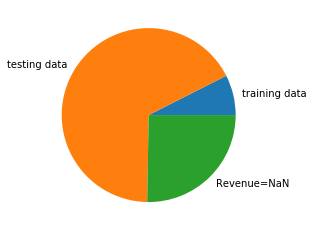

In [1]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots()
axs.pie([747, 6726, 2527], labels=['training data', 'testing data', 'Revenue=NaN'])
plt.show

- I created a pipeline to fill the "NaN"-value in other columns (e.g. "Metascore", "Score"). 
- used the training dataset and fittet it with the "DecisionTreeRegressor" model
- verified with a cross-validation, how good this model/parameters are
- did a prediction on a subset of the testing dataset and did a side-by-side comparison of prediction and true value
- performed a prediction on the testing dataset and calculated the mean-squared error

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import OneHotEncoder  we will need this later
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

In [3]:
PATH = os.path.join("datasets", "movies")

In [4]:
def format_plot(ax, title, feature1, feature2):
    #ax.xaxis.set_major_formatter(plt.NullFormatter())
    #ax.yaxis.set_major_formatter(plt.NullFormatter())
    ax.set_xlabel(feature1, color='gray')
    ax.set_ylabel(feature2, color='gray')
    ax.set_title(title, color='gray')

# Importing the data

The movies dataset can be found here: https://www.kaggle.com/isaactaylorofficial/imdb-10000-most-voted-feature-films-041118

In [5]:
def load_data(path=PATH):
    csv_path = os.path.join(path, "movies.csv")
    return pd.read_csv(csv_path)

In [6]:
movies = load_data()
movies.head()

,Rank,Title,Year,Score,Metascore,Genre,Vote,Director,Runtime,Revenue,Description
0,1,The Shawshank Redemption,1994,9.3,80.0,Drama,2011509,Frank Darabont,142,28.34,Two imprisoned men bond over a number of years...
1,2,The Dark Knight,2008,9.0,84.0,"Action, Crime, Drama",1980200,Christopher Nolan,152,534.86,When the menace known as the Joker emerges fro...
2,3,Inception,2010,8.8,74.0,"Action, Adventure, Sci-Fi",1760209,Christopher Nolan,148,292.58,A thief who steals corporate secrets through t...
3,4,Fight Club,1999,8.8,66.0,Drama,1609459,David Fincher,139,37.03,An insomniac office worker and a devil-may-car...
4,5,Pulp Fiction,1994,8.9,94.0,"Crime, Drama",1570194,Quentin Tarantino,154,107.93,"The lives of two mob hitmen, a boxer, a gangst..."


In [7]:
movies.dtypes

Rank             int64
Title           object
Year             int64
Score          float64
Metascore      float64
Genre           object
Vote             int64
Director        object
Runtime          int64
Revenue        float64
Description     object
dtype: object

In [8]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Rank         10000 non-null  int64  
 1   Title        10000 non-null  object 
 2   Year         10000 non-null  int64  
 3   Score        10000 non-null  float64
 4   Metascore    6781 non-null   float64
 5   Genre        10000 non-null  object 
 6   Vote         10000 non-null  int64  
 7   Director     9999 non-null   object 
 8   Runtime      10000 non-null  int64  
 9   Revenue      7473 non-null   float64
 10  Description  10000 non-null  object 
dtypes: float64(3), int64(4), object(4)
memory usage: 859.5+ KB


# "NaN"-values in column "Revenue"

In column "Revenue" there are 7473 "non-null" values, and 2527 "null" values:

In [9]:
10000-7473

2527

These are the datarows, where column "Revenue" is null: 

In [10]:
movies_RevenueNaN = movies[movies["Revenue"].isnull()]
movies_RevenueNaN.head()

,Rank,Title,Year,Score,Metascore,Genre,Vote,Director,Runtime,Revenue,Description
82,83,A Clockwork Orange,1971,8.3,80.0,"Crime, Drama, Sci-Fi",662768,Stanley Kubrick,136,NaN,"In the future, a sadistic gang leader is impri..."
513,514,To Kill a Mockingbird,1962,8.3,87.0,"Crime, Drama",262064,Robert Mulligan,129,NaN,"Atticus Finch, a lawyer in the Depression-era ..."
581,582,Death Proof,2007,7.0,NaN,"Action, Thriller",236539,Quentin Tarantino,113,NaN,Two separate sets of voluptuous women are stal...
620,621,My Neighbour Totoro,1988,8.2,86.0,"Animation, Family, Fantasy",226126,Hayao Miyazaki,86,NaN,When two girls move to the country to be near ...
685,686,Hachi: A Dog's Tale,2009,8.1,NaN,"Drama, Family",212349,Lasse Hallström,93,NaN,A college professor's bond with the abandoned ...


In [11]:
len_movies_RevenueNaN = len(movies_RevenueNaN)
len_movies_RevenueNaN

2527

In [12]:
movies_NotNull = movies[movies["Revenue"].notnull()]
movies_NotNull.head()

,Rank,Title,Year,Score,Metascore,Genre,Vote,Director,Runtime,Revenue,Description
0,1,The Shawshank Redemption,1994,9.3,80.0,Drama,2011509,Frank Darabont,142,28.34,Two imprisoned men bond over a number of years...
1,2,The Dark Knight,2008,9.0,84.0,"Action, Crime, Drama",1980200,Christopher Nolan,152,534.86,When the menace known as the Joker emerges fro...
2,3,Inception,2010,8.8,74.0,"Action, Adventure, Sci-Fi",1760209,Christopher Nolan,148,292.58,A thief who steals corporate secrets through t...
3,4,Fight Club,1999,8.8,66.0,Drama,1609459,David Fincher,139,37.03,An insomniac office worker and a devil-may-car...
4,5,Pulp Fiction,1994,8.9,94.0,"Crime, Drama",1570194,Quentin Tarantino,154,107.93,"The lives of two mob hitmen, a boxer, a gangst..."


In [13]:
len_movies_NotNull = len(movies_NotNull)
len_movies_NotNull

7473

In [14]:
len_movies_RevenueNaN + len_movies_NotNull

10000

<function matplotlib.pyplot.show(*args, **kw)>

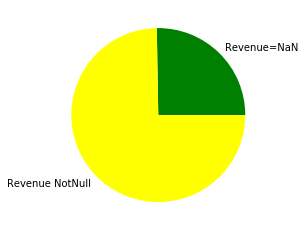

In [15]:
fig, axs = plt.subplots()
axs.pie([len_movies_RevenueNaN, len_movies_NotNull], 
        labels=['Revenue=NaN', 'Revenue NotNull'], 
        colors  = ['green', 'yellow']
       )
plt.show

# Visualisation of the data

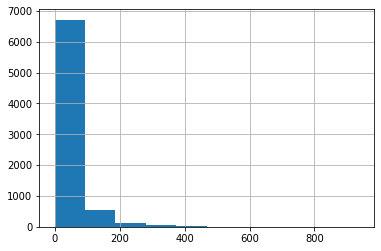

In [16]:
movies_NotNull['Revenue'].hist()

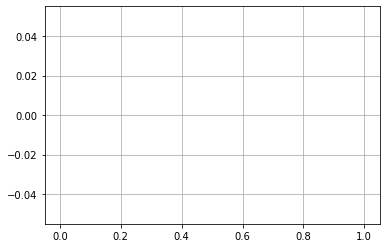

In [17]:
movies_RevenueNaN['Revenue'].hist()

Some scatter plots to see, how "Revenue", "Year" and "Score" behave: 

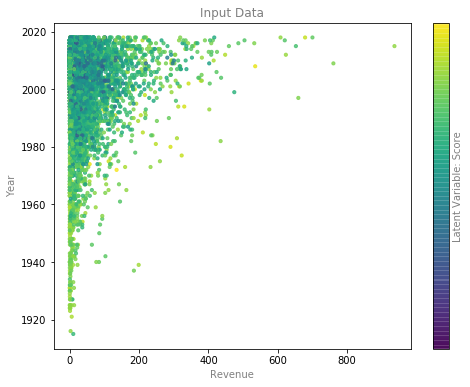

In [18]:
fig, ax = plt.subplots(figsize=(8, 6))
point_style = dict(cmap='Paired', s=50)
pts = ax.scatter(movies_NotNull['Revenue'], movies_NotNull['Year'], c=movies_NotNull['Score'], s=10, alpha=0.8)
cb = fig.colorbar(pts, ax=ax)

# format plot
format_plot(ax, 'Input Data', 'Revenue', 'Year')
cb.set_ticks([])
cb.set_label('Latent Variable: Score', color='gray')

fig.savefig('images/movies/movies_revenue_year_score.png')

The Revenue increased during the years from 1920 to 2020. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001965948A688>,
      dtype=object)

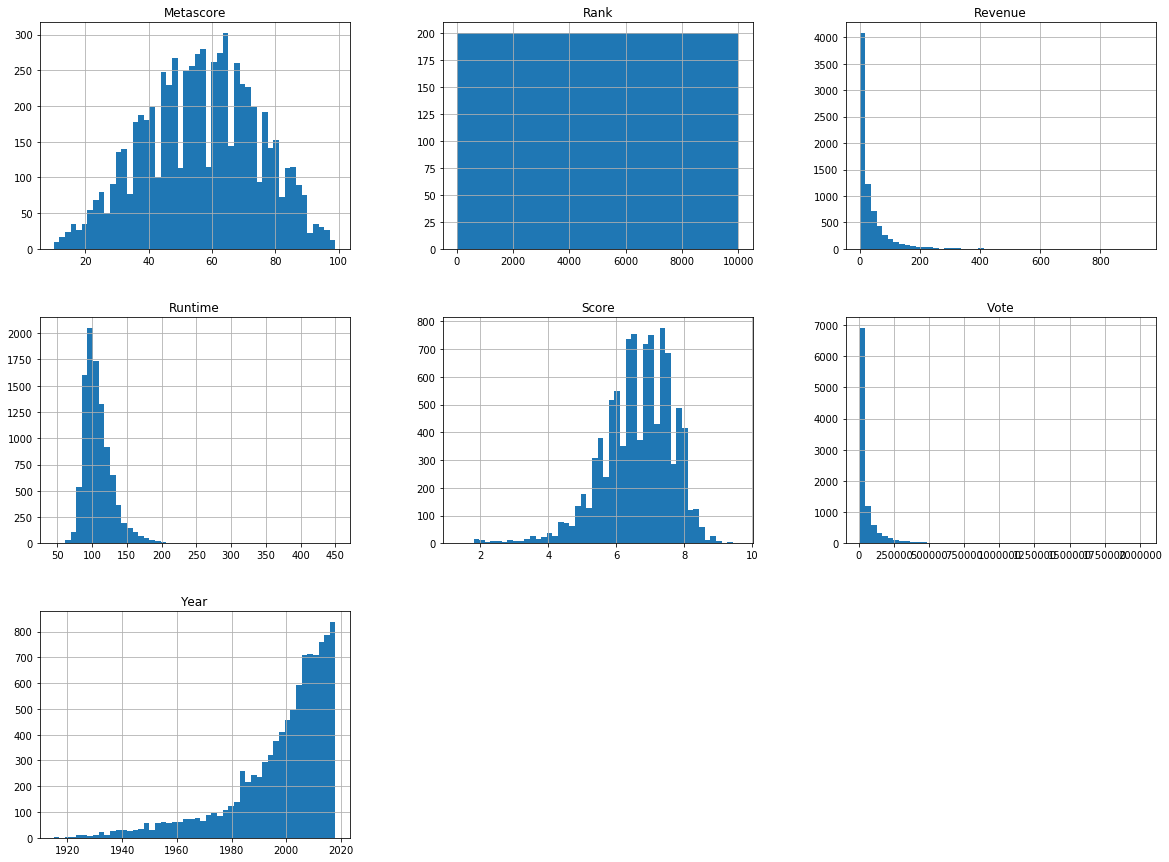

In [19]:
movies.hist(bins=50, figsize=(20,15))

As the "Rank" is a continuous ascending index, the histogramm looks like an rectangle. 
The "Runtime" of an average movie is about 100 minutes, which makes sense. 
The shape of the "Revenue" histogramm also seems so make sense. 
The "Metascore" and "Score" have some interesting jags, which is due to the discrete values (1,2,3... but not 1.24 or 3.73), which these values can take. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000019659496688>,
      dtype=object)

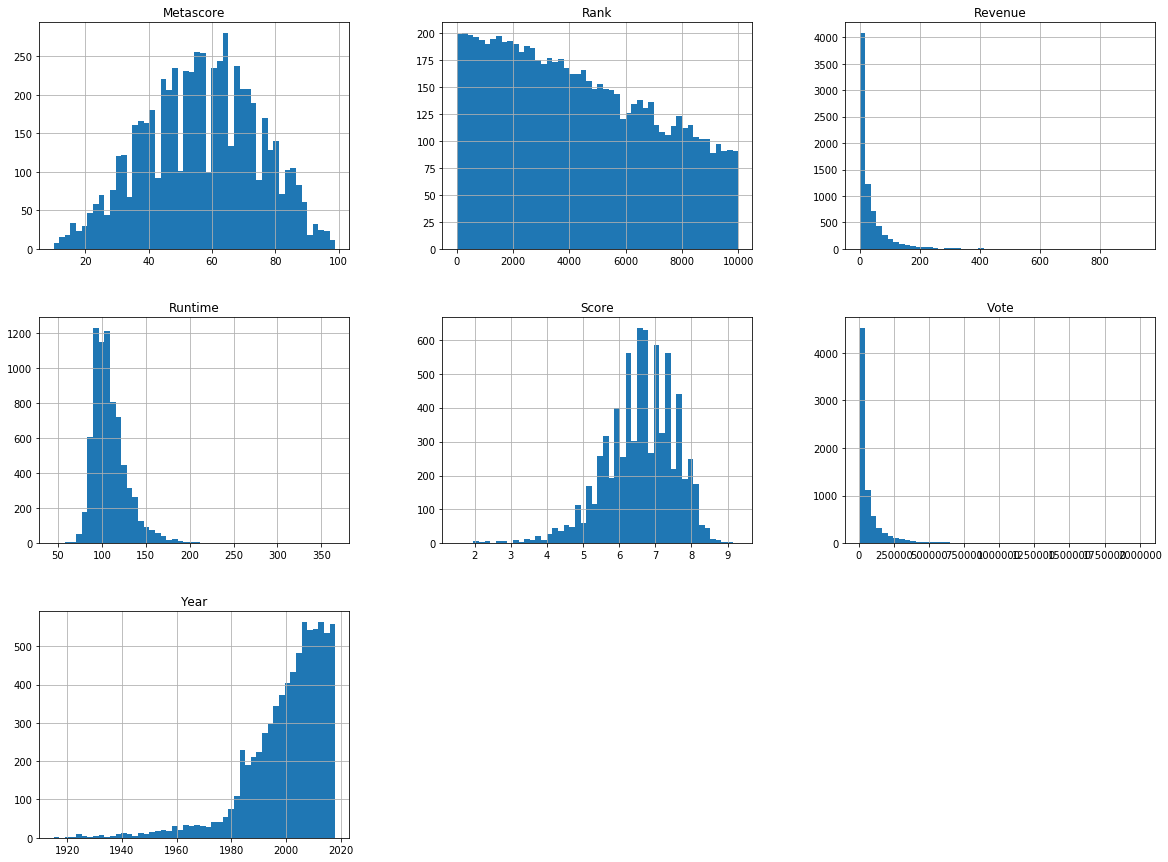

In [20]:
movies_NotNull.hist(bins=50, figsize=(20,15))

The difference in the "Rank" histogramm is because the row "NaN"-values in column "Revenue" are not included here. 

Examine how "Year", "Score" and "Revenue" behave: 

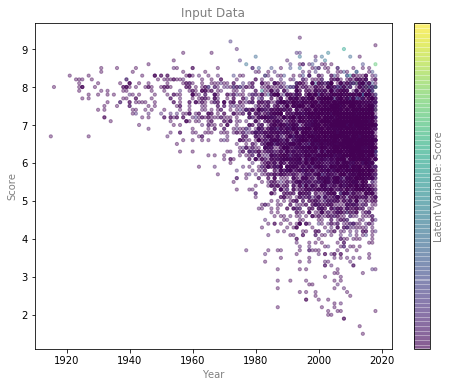

In [21]:
fig, ax = plt.subplots(figsize=(8, 6))
point_style = dict(cmap='Paired', s=50)
pts = ax.scatter(movies_NotNull['Year'], movies_NotNull['Score'], c=movies_NotNull['Revenue'], s=10, alpha=0.4)
cb = fig.colorbar(pts, ax=ax)

# format plot
format_plot(ax, 'Input Data', 'Year', 'Score')
cb.set_ticks([])
cb.set_label('Latent Variable: Score', color='gray')

fig.savefig('images/movies/movies_year_score_revenue.png')

In 1920 most movies hat a score of 8. In 2020 most movies had a score between about 4 and 9. I think this is a bit strange, because I would have expected, that there are also movies with a lower score in 1920. 

# Stratified Sampling

In [22]:
movies_NotNullC = movies_NotNull[:].copy(deep=True)

In [23]:
movies_NotNullC['RevCat']=pd.cut(movies_NotNullC['Revenue'], 
                        bins=[-1,100,200,300,np.inf], 
                        labels=[1, 2, 3, 4])
movies_NotNullC['RevCat'].value_counts()

1    6753
2     522
3     120
4      78
Name: RevCat, dtype: int64

In [24]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.9, random_state=42)
for train_index, test_index in split.split(movies_NotNullC, movies_NotNullC["RevCat"]):
    strat_train_set = movies_NotNullC.iloc[train_index]
    strat_test_set = movies_NotNullC.iloc[test_index]

In [25]:
strat_test_set["RevCat"].value_counts() / len(strat_test_set)

1    0.903657
2    0.069878
3    0.016057
4    0.010407
Name: RevCat, dtype: float64

In [26]:
movies_NotNullC["RevCat"].value_counts() / len(movies_NotNullC)

1    0.903653
2    0.069851
3    0.016058
4    0.010438
Name: RevCat, dtype: float64

In [27]:
def revenue_cat_proportions(data):
    return data["RevCat"].value_counts() / len(data)

train_set, test_set = train_test_split(movies_NotNullC, test_size=0.9, random_state=42)

compare_props = pd.DataFrame({
    "Overall": revenue_cat_proportions(movies_NotNullC),
    "Stratified": revenue_cat_proportions(strat_test_set),
    "Random": revenue_cat_proportions(test_set),
}).sort_index()

compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

print(compare_props)

for set_ in (strat_train_set, strat_test_set):
    set_.drop("RevCat", axis=1, inplace=True)

    Overall  Stratified    Random  Rand. %error  Strat. %error
1  0.903653    0.903657  0.903063     -0.065336       0.000476
2  0.069851    0.069878  0.069432     -0.600432       0.038109
3  0.016058    0.016057  0.016652      3.699078      -0.004460
4  0.010438    0.010407  0.010853      3.983966      -0.289348


C:\Users\andre\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [28]:
movies_train = strat_train_set.drop('Revenue', axis=1)
movies_train_labels = strat_train_set['Revenue'].copy()
len_movies_train = len(movies_train)
len_movies_train

747

In [29]:
movies_test = strat_test_set.drop('Revenue', axis=1)
movies_test_labels = strat_test_set['Revenue'].copy()
len_movies_test = len(movies_test)
len_movies_test

6726

In [30]:
len_movies_train + len_movies_test

7473

In [31]:
len_movies_NotNull

7473

In [32]:
len_movies_RevenueNaN

2527

In [33]:
len_movies_train + len_movies_test + len_movies_RevenueNaN 

10000

The whole dataset of 10000 rows has been split up into 
- a training dataset ("movies_train"), 
- a testing dataset ("movies_test") and
- a dataset, where "Revenue"="NaN"

<function matplotlib.pyplot.show(*args, **kw)>

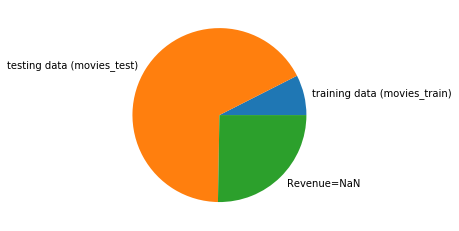

In [34]:
fracs = [len_movies_train, len_movies_test, len_movies_RevenueNaN]
labels = ['training data (movies_train)', 'testing data (movies_test)', 'Revenue=NaN']
fig, axs = plt.subplots()
axs.pie(fracs, labels=labels)
plt.show

In [35]:
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

# Pipeline

Now I want to implement a pipeline for doing all the datapreparation work quicker when I am testing it later. Only numerical-columns will be taken. The other will be thrown away (for the moment, I will change this later): 

In [36]:
imputer = SimpleImputer(strategy="median")
movies_train_num = movies_train.select_dtypes(include=[np.number])
imputer.fit(movies_train_num)
X = imputer.transform(movies_train_num) # Transform the training set:
movies_tr = pd.DataFrame(X, columns=movies_train_num.columns,index=movies_train.index)
movies_tr.head()

,Rank,Year,Score,Metascore,Vote,Runtime
733,734.0,2007.0,6.3,68.0,204005.0,86.0
5851,5852.0,2003.0,5.2,21.0,16061.0,102.0
3816,3817.0,2003.0,5.3,47.0,33688.0,116.0
5384,5385.0,1980.0,6.7,58.0,18517.0,103.0
1058,1059.0,1998.0,6.7,63.0,152346.0,136.0


In [37]:
num_attribs = list(movies_train_num)
num_attribs

['Rank', 'Year', 'Score', 'Metascore', 'Vote', 'Runtime']

In [38]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), 
])

num_attribs = ['Rank', 'Year', 'Score', 'Metascore', 'Vote', 'Runtime'] #list(movies_train_num)

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs)
])

Apply now the full pipeline on the training-dataset "movies_train". But before we do this, we have a look into the column "Metascore" and count how many "nan"-values we have there in the training dataset "movies_train": 

In [39]:
tmp = movies_train[movies_train["Metascore"].isnull()]
tmp.head()

,Rank,Title,Year,Score,Metascore,Genre,Vote,Director,Runtime,Description
5384,5385,The Final Countdown,1980,6.7,NaN,"Action, Sci-Fi",18517,Don Taylor,103,A modern aircraft carrier is thrown back in ti...
5914,5915,The Chase,1994,5.8,NaN,"Action, Adventure, Comedy",15791,Adam Rifkin,89,Escaped convict Jack Hammond takes a woman hos...
8964,8965,Smokey and the Bandit Part 3,1983,3.4,NaN,"Comedy, Crime",7276,Dick Lowry,85,Big and Little Enos are opening a sea food res...
2639,2640,Charade,1963,8.0,NaN,"Comedy, Mystery, Romance",57719,Stanley Donen,113,Romance and suspense ensue in Paris as a woman...
7876,7877,Auntie Mame,1958,8.0,NaN,"Comedy, Drama, Romance",9186,Morton DaCosta,143,An orphan goes to live with his free-spirited ...


Now apply the Pipeline:

In [40]:
movies_train_prepared = full_pipeline.fit_transform(movies_train)

Now let's count the "nan" values in the new prepared datast "movies_train_prepared". I have to transform it back to a Pandas-Dataframe format first: 

In [41]:
tmp_num = movies_train.select_dtypes(include=[np.number])
tmp_prep = pd.DataFrame(movies_train_prepared, columns=tmp_num.columns,index=movies_train.index)
tmp = tmp_prep[tmp_prep["Metascore"].isnull()]
tmp

,Rank,Year,Score,Metascore,Vote,Runtime


Zero, as we wanted! All "nan"-values in "movies_train_prepared" have been removed by the "median" value (this was how the pipeline was built). Great, this was part of the job, the Pipline should have done.  The other part was to eliminate some columns. We now have only 6 remaining instead of 10 columns. 

# Model "DecisionTreeRegressor"

In [42]:
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(movies_train_prepared, movies_train_labels)

movies_predictions = tree_reg.predict(movies_train_prepared)

Verifiy if training labels ("movies_train_labels") and predicted labels ("movies_predictions"). Here for the first 10 datasets:

In [43]:
list(movies_train_labels[0:10])

[107.92, 7.66, 30.01, 16.65, 94.1, 11.54, 6.61, 126.64, 3.63, 1.57]

In [44]:
list(movies_predictions[0:10])

[107.92, 7.66, 30.01, 16.65, 94.1, 11.54, 6.61, 126.64, 3.63, 1.57]

The training-labels and the predicted labels match for the first 10 datasets. The fitting of the model was successful.

How big is the error for all training-datasets?

In [45]:
trainmse = mean_squared_error(movies_train_labels, movies_predictions)
trainrmse = np.sqrt(trainmse)
trainrmse

0.0

# Cross-Validation

In [46]:
scores = cross_val_score(tree_reg, 
                         movies_train_prepared,
                         movies_train_labels,
                         scoring="neg_mean_squared_error", 
                         cv=10)

rmse_scores = np.sqrt(-scores)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(rmse_scores)

Scores: [ 69.66166984  62.59977724  62.6450061  112.98391756  47.99491086
  52.16787811  42.65104005  83.21059338  41.09199207  63.84158945]
Mean: 63.88483746577791
Standard deviation: 20.447326452253154


# Test the model

We take on arbitrary row in the testing dataset "movies_test". Take for example row number 322:

In [47]:
some_data = movies_test.iloc[0:20]
some_data_label = movies_test_labels.iloc[0:20]

In [48]:
some_data

,Rank,Title,Year,Score,Metascore,Genre,Vote,Director,Runtime,Description
3123,3124,Victor Frankenstein,2015,6.0,36.0,"Drama, Horror, Sci-Fi",45259,Paul McGuigan,110,"Told from Igor's perspective, we see the troub..."
3061,3062,Battleship Potemkin,1925,8.0,NaN,"Drama, History",46636,Sergei M. Eisenstein,75,In the midst of the Russian Revolution of 1905...
3627,3628,Bakjwi,2009,7.2,73.0,"Drama, Horror, Romance",36395,Chan-wook Park,135,"Through a failed medical experiment, a priest ..."
695,696,The Sting,1973,8.3,80.0,"Comedy, Crime, Drama",211112,George Roy Hill,129,Two grifters team up to pull off the ultimate ...
2633,2634,The Gambler,2014,6.0,55.0,"Crime, Drama, Thriller",57874,Rupert Wyatt,111,Literature professor and gambler Jim Bennett's...
2156,2157,xXx: Return of Xander Cage,2017,5.2,42.0,"Action, Adventure, Thriller",73717,D.J. Caruso,107,Xander Cage is left for dead after an incident...
2307,2308,Rock of Ages,2012,5.9,47.0,"Comedy, Drama, Musical",68455,Adam Shankman,123,A small town girl and a city boy meet on the S...
2979,2980,Arthur,2011,5.7,36.0,"Comedy, Romance",48239,Jason Winer,110,A drunken playboy stands to lose a wealthy inh...
408,409,Vertigo,1958,8.3,NaN,"Mystery, Romance, Thriller",306510,Alfred Hitchcock,128,A former police detective juggles wrestling wi...
1172,1173,Invictus,2009,7.3,74.0,"Biography, Drama, History",137826,Clint Eastwood,134,"Nelson Mandela, in his first term as the South..."


As we didn't apply the pipeline on the testing dataset (we only did on the training dataset "movies_train"), there might still some "nan" values in columns "Metascore".

The true value for the "Revenue" is: 

In [49]:
some_data_label

3123      5.78
3061      0.05
3627      0.30
695     159.60
2633     33.63
2156     44.90
2307     38.52
2979     33.04
408       3.20
1172     37.49
5560     17.88
1255     41.19
2506     16.19
6044      0.05
5681     16.68
4592     35.11
7155     36.00
5046      3.61
8001      0.59
3866      0.99
Name: Revenue, dtype: float64

This row is the same as the following dataset from the original "movies"-database:

In [50]:
some_movies = movies.iloc[some_data.index[0:len(some_data)]]
some_movies

,Rank,Title,Year,Score,Metascore,Genre,Vote,Director,Runtime,Revenue,Description
3123,3124,Victor Frankenstein,2015,6.0,36.0,"Drama, Horror, Sci-Fi",45259,Paul McGuigan,110,5.78,"Told from Igor's perspective, we see the troub..."
3061,3062,Battleship Potemkin,1925,8.0,NaN,"Drama, History",46636,Sergei M. Eisenstein,75,0.05,In the midst of the Russian Revolution of 1905...
3627,3628,Bakjwi,2009,7.2,73.0,"Drama, Horror, Romance",36395,Chan-wook Park,135,0.30,"Through a failed medical experiment, a priest ..."
695,696,The Sting,1973,8.3,80.0,"Comedy, Crime, Drama",211112,George Roy Hill,129,159.60,Two grifters team up to pull off the ultimate ...
2633,2634,The Gambler,2014,6.0,55.0,"Crime, Drama, Thriller",57874,Rupert Wyatt,111,33.63,Literature professor and gambler Jim Bennett's...
2156,2157,xXx: Return of Xander Cage,2017,5.2,42.0,"Action, Adventure, Thriller",73717,D.J. Caruso,107,44.90,Xander Cage is left for dead after an incident...
2307,2308,Rock of Ages,2012,5.9,47.0,"Comedy, Drama, Musical",68455,Adam Shankman,123,38.52,A small town girl and a city boy meet on the S...
2979,2980,Arthur,2011,5.7,36.0,"Comedy, Romance",48239,Jason Winer,110,33.04,A drunken playboy stands to lose a wealthy inh...
408,409,Vertigo,1958,8.3,NaN,"Mystery, Romance, Thriller",306510,Alfred Hitchcock,128,3.20,A former police detective juggles wrestling wi...
1172,1173,Invictus,2009,7.3,74.0,"Biography, Drama, History",137826,Clint Eastwood,134,37.49,"Nelson Mandela, in his first term as the South..."


Lets predict the revenue for this dataset:

In [51]:
some_data_prepared = full_pipeline.fit_transform(some_data)
some_data_predictions = tree_reg.predict(some_data_prepared)
list(some_data_predictions)

[10.91,
 0.44,
 2.68,
 11.99,
 2.19,
 26.83,
 22.52,
 2.19,
 11.99,
 16.38,
 64.19,
 191.45,
 12.19,
 3.02,
 64.19,
 11.54,
 40.22,
 19.64,
 0.05,
 5.48]

Compare this prediction to the value "some_data_label". 

In [52]:
list(some_data_label)

[5.78,
 0.05,
 0.3,
 159.6,
 33.63,
 44.9,
 38.52,
 33.04,
 3.2,
 37.49,
 17.88,
 41.19,
 16.19,
 0.05,
 16.68,
 35.11,
 36.0,
 3.61,
 0.59,
 0.99]

Compare the true value ("some_data_labels") and the predicted value ("some_data_predicitons") side-by-side. Left side is the true value from the original movies dataset. Right side is the predicted value based on the tree model: 

In [53]:
side_by_side = [(true, pred) for true, pred in zip(list(some_data_label), list(some_data_predictions))]
side_by_side

[(5.78, 10.91),
 (0.05, 0.44),
 (0.3, 2.68),
 (159.6, 11.99),
 (33.63, 2.19),
 (44.9, 26.83),
 (38.52, 22.52),
 (33.04, 2.19),
 (3.2, 11.99),
 (37.49, 16.38),
 (17.88, 64.19),
 (41.19, 191.45),
 (16.19, 12.19),
 (0.05, 3.02),
 (16.68, 64.19),
 (35.11, 11.54),
 (36.0, 40.22),
 (3.61, 19.64),
 (0.59, 0.05),
 (0.99, 5.48)]

The mean-squared-error is as follows: 

In [54]:
mse = mean_squared_error(some_data_label, some_data_predictions)
rmse = np.sqrt(mse)
rmse

51.3429319867886

Taking now the whole testing dataset: 

In [55]:
movies_test_prepared =full_pipeline.fit_transform(movies_test)
movies_test_predictions = tree_reg.predict(movies_test_prepared)
lin_mse = mean_squared_error(movies_test_labels, movies_test_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

54.68522284077671

In [56]:
movies_test_labels.mean()

36.2082738626228

In [57]:
movies_test_labels.std()

60.602745133524195

A side-by-side comparison off the testing dataset. Left side is the true value from the original movies dataset. Right side is the predicted value based on the tree model: 

In [58]:
side_by_side = [(true, pred) for true, pred in zip(list(movies_test_labels), list(movies_test_predictions))]
side_by_side

[(5.78, 10.91),
 (0.05, 0.44),
 (0.3, 2.68),
 (159.6, 11.99),
 (33.63, 2.19),
 (44.9, 26.83),
 (38.52, 22.52),
 (33.04, 2.19),
 (3.2, 11.99),
 (37.49, 16.38),
 (17.88, 64.19),
 (41.19, 191.45),
 (16.19, 12.19),
 (0.05, 3.02),
 (16.68, 64.19),
 (35.11, 11.54),
 (36.0, 40.22),
 (3.61, 19.64),
 (0.59, 0.05),
 (0.99, 5.48),
 (26.12, 107.53),
 (0.0, 0.02),
 (3.45, 18.0),
 (18.87, 12.5),
 (7.92, 42.44),
 (0.67, 2.5),
 (6.11, 119.22),
 (22.92, 55.68),
 (1.54, 61.19),
 (0.9, 61.19),
 (35.38, 92.12),
 (2.49, 29.6),
 (22.0, 14.18),
 (44.34, 15.16),
 (0.77, 4.16),
 (9.8, 6.88),
 (46.46, 28.84),
 (34.25, 16.65),
 (5.88, 37.02),
 (0.02, 7.94),
 (29.13, 19.52),
 (4.91, 22.6),
 (9.06, 14.72),
 (1.83, 0.06),
 (51.73, 9.07),
 (8.91, 24.05),
 (94.01, 119.44),
 (0.15, 4.16),
 (68.54, 216.39),
 (24.15, 8.7),
 (30.63, 64.19),
 (21.37, 48.61),
 (0.01, 0.05),
 (4.06, 0.47),
 (5.11, 15.7),
 (1.11, 5.48),
 (4.04, 2.15),
 (219.96, 76.42),
 (12.32, 16.65),
 (0.03, 11.41),
 (20.35, 43.25),
 (64.06, 11.65),
 (10.4

Plotting the true labels and the predicted labels on the testing dataset: 

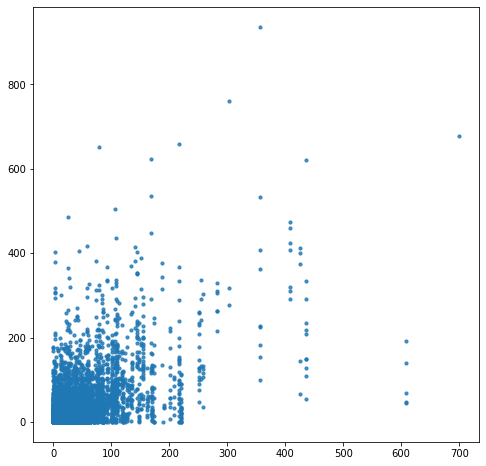

In [59]:
fig, ax = plt.subplots(figsize=(8, 8))
pts = ax.scatter(movies_test_predictions, movies_test_labels, s=10, alpha=0.8)

Looks confusing. I would have expected something a bit more similar to the following plot.

Plotting the same for the training dataset: 

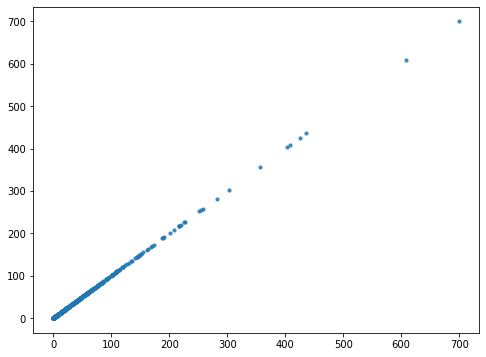

In [60]:
movies_train_prepared =full_pipeline.fit_transform(movies_train)
movies_train_predictions = tree_reg.predict(movies_train_prepared)
fig, ax = plt.subplots(figsize=(8, 6))
pts = ax.scatter(movies_train_predictions, movies_train_labels, s=10, alpha=0.8)

Now I calculate the "Revenue" where it has "NaN"-values:

In [61]:
movies_RevenueNaN_prepared =full_pipeline.fit_transform(movies_RevenueNaN)
movies_RevenueNaN_predictions = tree_reg.predict(movies_RevenueNaN_prepared)

These are the predictions:

In [62]:
movies_RevenueNaN_predictions

array([74.1 , 11.99, 83.08, ...,  2.98, 43.49, 47.29])

I will insert the prediction into the dataset:

In [63]:
movies_RevenueNaN.loc[:,"Revenue"] = movies_RevenueNaN_predictions

C:\Users\andre\Anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [64]:
movies_RevenueNaN

,Rank,Title,Year,Score,Metascore,Genre,Vote,Director,Runtime,Revenue,Description
82,83,A Clockwork Orange,1971,8.3,80.0,"Crime, Drama, Sci-Fi",662768,Stanley Kubrick,136,74.10,"In the future, a sadistic gang leader is impri..."
513,514,To Kill a Mockingbird,1962,8.3,87.0,"Crime, Drama",262064,Robert Mulligan,129,11.99,"Atticus Finch, a lawyer in the Depression-era ..."
581,582,Death Proof,2007,7.0,NaN,"Action, Thriller",236539,Quentin Tarantino,113,83.08,Two separate sets of voluptuous women are stal...
620,621,My Neighbour Totoro,1988,8.2,86.0,"Animation, Family, Fantasy",226126,Hayao Miyazaki,86,75.08,When two girls move to the country to be near ...
685,686,Hachi: A Dog's Tale,2009,8.1,NaN,"Drama, Family",212349,Lasse Hallström,93,75.08,A college professor's bond with the abandoned ...
...,...,...,...,...,...,...,...,...,...,...,...
9993,9994,The Infidel,2010,6.4,57.0,"Comedy, Drama",6024,Josh Appignanesi,105,43.49,An identity crisis comedy centred on Mahmud Na...
9996,9997,Stachka,1925,7.6,NaN,Drama,6021,Sergei M. Eisenstein,95,0.10,A group of oppressed factory workers go on str...
9997,9998,November Criminals,2017,5.3,31.0,"Crime, Drama, Mystery",6020,Sacha Gervasi,85,2.98,"After his friend is murdered, a Washington, D...."
9998,9999,120,2008,7.3,NaN,"Drama, History, War",6018,Özhan Eren,114,43.49,"During the Sarikamis Battle, the Ottoman army ..."


# Future amendments

The movies dataset has the following columns (including "Revenue" which I wanted to predict):

In [65]:
movies.head(0)

,Rank,Title,Year,Score,Metascore,Genre,Vote,Director,Runtime,Revenue,Description


But the model is only taking the follwing columns into consideration: 

In [66]:
num_attribs

['Rank', 'Year', 'Score', 'Metascore', 'Vote', 'Runtime']

Remember, that the dataset, which is used for the model looks as follows (all non-numeric columns disappeared): 

In [67]:
movies_tr

,Rank,Year,Score,Metascore,Vote,Runtime
733,734.0,2007.0,6.3,68.0,204005.0,86.0
5851,5852.0,2003.0,5.2,21.0,16061.0,102.0
3816,3817.0,2003.0,5.3,47.0,33688.0,116.0
5384,5385.0,1980.0,6.7,58.0,18517.0,103.0
1058,1059.0,1998.0,6.7,63.0,152346.0,136.0
...,...,...,...,...,...,...
9623,9624.0,1994.0,6.6,58.0,6425.0,108.0
2687,2688.0,2003.0,5.6,28.0,56578.0,116.0
2346,2347.0,1988.0,6.8,29.0,67287.0,92.0
384,385.0,1990.0,7.6,60.0,317490.0,162.0


Therefore lot's of information, which is in the dataset has not yet been used, e.g. "Genre", "Director". These information could have an positive impact on the correctness of the predictions.  

But as "Genre" has 486 different values it is a bit more complicated to treat them as "categorial" values:

In [68]:
movies['Genre'].value_counts()

Comedy, Drama, Romance     494
Drama                      482
Comedy, Drama              407
Drama, Romance             365
Comedy                     357
                          ... 
Action, Fantasy, War         1
War                          1
Musical, Romance, War        1
Comedy, Romance, Family      1
Crime, Drama, Western        1
Name: Genre, Length: 486, dtype: int64

As already mentionned right in the beginning of this Jupyter-Notebook the "OneHotEncoder" could be used. But before we should work on these 486 categorial values: could we simplify it, e.g. extract "Drama" and use it as a separate criteria? I will do this in another notebook. 